### Importing Necessary Libraries

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
# from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [4]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [5]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [6]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [7]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

In [8]:
roi_info = np.load('./Data/ROI-Extractions/train/train_roi_viz.npy')
roi_info.shape

(16000, 100, 6)

In [9]:
roi_count = [np.sum([roi[-1]==1 for roi in doc]) for doc in roi_info] # RoIs per document Image

## Data Preparation

We have already generated the Extracted Feature Vectors from the ResNet Model now we train using that, so we load those feature vectors.

In [10]:
# fine_tune_data_resnet = np.load('./Data/ResNet-kP-train-precompute/whole_train_data_precomp.npy')
# fine_tune_data_resnet.shape

In [11]:
# fine_tune_data_vgg = np.load('./Data/VGG16-kP-train-precompute/whole_train_data_precomp.npy')
# fine_tune_data_vgg.shape

In [12]:
# fine_tune_data_inception_resnet = np.load('./Data/Inception-ResNet-kP-train-precompute/whole_train_data_precomp.npy')
# fine_tune_data_inception_resnet.shape

In [13]:
# fine_tune_data = np.concatenate([fine_tune_data_resnet, fine_tune_data_vgg, fine_tune_data_inception_resnet], axis=-1)
# del fine_tune_data_resnet
# del fine_tune_data_vgg
# del fine_tune_data_inception_resnet
# fine_tune_data.shape

In [14]:
# np.save('./Data/ResNet-VGG-Inception-kP-train-precompute/whole_train_data_precomp.npy', fine_tune_data)

In [15]:
# fine_tune_data = np.load('./Data/ResNet-VGG-Inception-kP-train-precompute/whole_train_data_precomp.npy')
# fine_tune_data.shape

In [16]:
# fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
# fine_tune_data_train.shape

In [17]:
# roi_count_train = [roi_count[idx] for idx in list(train_labels['id'])]
# fine_tune_data_train_no_pads = np.concatenate([fine_tune_data_train[i,:roi_count_train[i],:] for i in range(fine_tune_data_train.shape[0])])
# fine_tune_data_train_no_pads.shape

In [18]:
# np.save('./Data/ResNet-VGG-Inception-kP-train-precompute/whole_train_train_data_precomp_no_pads.npy', fine_tune_data_train_no_pads)

In [19]:
roi_count_train = [roi_count[idx] for idx in list(train_labels['id'])]
fine_tune_data_train_no_pads = np.load('./Data/ResNet-VGG-Inception-kP-train-precompute/whole_train_train_data_precomp_no_pads.npy')
fine_tune_data_train_no_pads.shape

(242726, 4096)

In [21]:
# fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
# fine_tune_data_test.shape

In [22]:
# roi_count_test = [roi_count[idx] for idx in list(test_labels['id'])]
# fine_tune_data_test_no_pads = np.concatenate([fine_tune_data_test[i,:roi_count_test[i],:] for i in range(fine_tune_data_test.shape[0])])
# fine_tune_data_test_no_pads.shape

In [23]:
# np.save('./Data/ResNet-VGG-Inception-kP-train-precompute/whole_train_test_data_precomp_no_pads.npy', fine_tune_data_test_no_pads)

In [24]:
roi_count_test = [roi_count[idx] for idx in list(test_labels['id'])]
fine_tune_data_test_no_pads = np.load('./Data/ResNet-VGG-Inception-kP-train-precompute/whole_train_test_data_precomp_no_pads.npy')
fine_tune_data_test_no_pads.shape

(13154, 4096)

In [48]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [49]:
# fine_tune_data_no_pads = np.concatenate([fine_tune_data[i,:roi_count[i],:] for i in range(fine_tune_data.shape[0])])
# fine_tune_data_no_pads.shape

In [50]:
# np.save('./Data/ResNet-VGG-Inception-kP-train-precompute/whole_train_data_precomp_no_pads.npy', fine_tune_data_no_pads)

In [51]:
# fine_tune_data_roi = np.load('./Data/ResNet-VGG-Inception-kP-train-precompute/whole_train_data_precomp_no_pads.npy')
# fine_tune_data_roi.shape

In [52]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [53]:
fine_tune_labels_train_no_pads = [[label]*roi_count_train[i] for i, label in enumerate(list(fine_tune_labels_train))]
fine_tune_labels_train_no_pads = np.array([label for label_set in fine_tune_labels_train_no_pads for label in label_set])
fine_tune_labels_train.shape

(15200,)

In [54]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

In [55]:
fine_tune_labels_test_no_pads = [[label]*roi_count_test[i] for i, label in enumerate(list(fine_tune_labels_test))]
fine_tune_labels_test_no_pads = np.array([label for label_set in fine_tune_labels_test_no_pads for label in label_set])
fine_tune_labels_test_no_pads.shape

(13154,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [56]:
def ftmodel():
    inputs = Input(shape=(4096,))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.5
    x = Dropout(top_dropout_rate)(x)
    x = Dense(2048,  kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate)(x)
    x = Dense(1024, kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate)(x)
    x = Dense(512, kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate)(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='RestNet-VGG-Inception-ResNet-RoI-FineTune')
    return model1

In [57]:
model1 = ftmodel()
model1.summary()

Model: "RestNet-VGG-Inception-ResNet-RoI-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4096)]            0         
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 2048)              8390656   
                                                                 
 batch_normalization_5 (Batc  (None, 2048)             8192      
 hNormalization)         

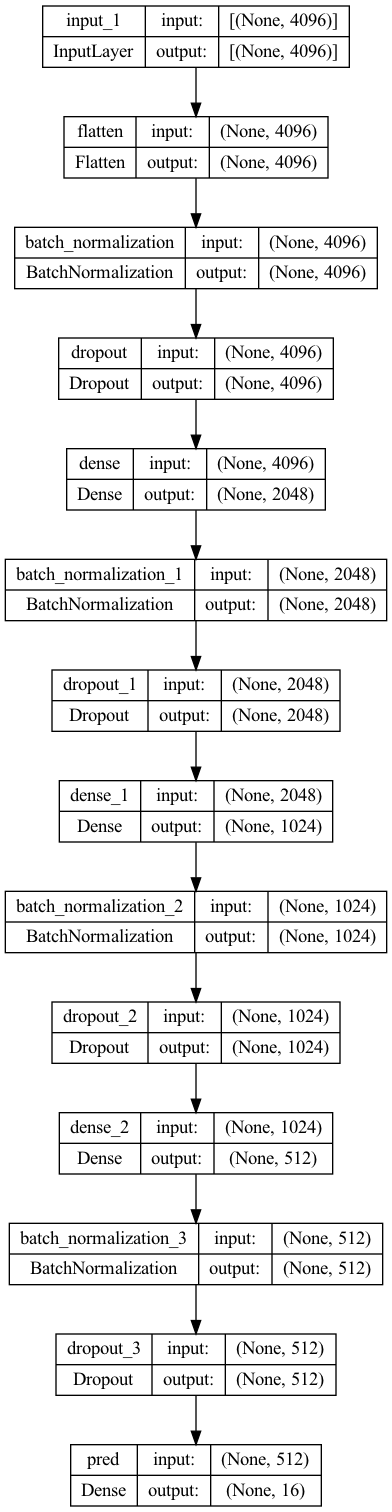

In [31]:
# tf.keras.utils.plot_model(model1, show_shapes=True, to_file='./Images/ResNet-VGG-Inception-ResNet-RoI-Model.png')

### Model Training

In [58]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [59]:
EPOCHS = 2000
checkpoint_filepaths = ['./Models/ResNet-VGG-Inception-ResNet-RoI/auto-ResNet-VGG-Inception-ResNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [60]:
history = model1.fit(fine_tune_data_train_no_pads, fine_tune_labels_train_no_pads, epochs=EPOCHS, batch_size=1003, validation_data=(fine_tune_data_test_no_pads, fine_tune_labels_test_no_pads), validation_batch_size=1000, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/ResNet-VGG-Inception-ResNet-RoI/resnet-vgg-inception-resnet-roi-model-weights")
model1.load_weights('./Models/ResNet-VGG-Inception-ResNet-RoI/resnet-vgg-inception-resnet-roi-model-weights')

Epoch 1/2000


2022-10-10 22:24:02.604401: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-10 22:24:03.067231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - ETA: 0s - loss: 3.2974 - accuracy: 0.1500

2022-10-10 22:24:08.967862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


242/242 [==============================] - 7s 24ms/step - loss: 3.2974 - accuracy: 0.1500 - val_loss: 2.8768 - val_accuracy: 0.2039
Epoch 2/2000
242/242 [==============================] - 5s 22ms/step - loss: 2.8779 - accuracy: 0.2004 - val_loss: 2.7386 - val_accuracy: 0.2454
Epoch 3/2000
242/242 [==============================] - 5s 22ms/step - loss: 2.7600 - accuracy: 0.2286 - val_loss: 2.6420 - val_accuracy: 0.2619
Epoch 4/2000
242/242 [==============================] - 5s 22ms/step - loss: 2.6930 - accuracy: 0.2467 - val_loss: 2.5913 - val_accuracy: 0.2850
Epoch 5/2000
242/242 [==============================] - 5s 22ms/step - loss: 2.6408 - accuracy: 0.2614 - val_loss: 2.5455 - val_accuracy: 0.2959
Epoch 6/2000
242/242 [==============================] - 5s 22ms/step - loss: 2.6004 - accuracy: 0.2713 - val_loss: 2.5096 - val_accuracy: 0.2978
Epoch 7/2000
242/242 [==============================] - 5s 22ms/step - loss: 2.5633 - accuracy: 0.2803 - val_loss: 2.4751 - val_accuracy: 0.310

242/242 [==============================] - 6s 24ms/step - loss: 2.0535 - accuracy: 0.4170 - val_loss: 2.1562 - val_accuracy: 0.3944
Epoch 58/2000
242/242 [==============================] - 6s 26ms/step - loss: 2.0486 - accuracy: 0.4190 - val_loss: 2.1569 - val_accuracy: 0.3932
Epoch 59/2000
242/242 [==============================] - 6s 25ms/step - loss: 2.0474 - accuracy: 0.4191 - val_loss: 2.1527 - val_accuracy: 0.3939
Epoch 60/2000
242/242 [==============================] - 6s 25ms/step - loss: 2.0423 - accuracy: 0.4222 - val_loss: 2.1542 - val_accuracy: 0.3961
Epoch 61/2000
242/242 [==============================] - 6s 25ms/step - loss: 2.0411 - accuracy: 0.4228 - val_loss: 2.1559 - val_accuracy: 0.3977
Epoch 62/2000
242/242 [==============================] - 6s 25ms/step - loss: 2.0372 - accuracy: 0.4248 - val_loss: 2.1544 - val_accuracy: 0.3960
Epoch 63/2000
242/242 [==============================] - 6s 25ms/step - loss: 2.0355 - accuracy: 0.4250 - val_loss: 2.1520 - val_accuracy:

242/242 [==============================] - 6s 25ms/step - loss: 1.9705 - accuracy: 0.4578 - val_loss: 2.1888 - val_accuracy: 0.4089
Epoch 114/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.9692 - accuracy: 0.4591 - val_loss: 2.1907 - val_accuracy: 0.4087
Epoch 115/2000
242/242 [==============================] - 6s 27ms/step - loss: 1.9661 - accuracy: 0.4591 - val_loss: 2.1936 - val_accuracy: 0.4088
Epoch 116/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.9691 - accuracy: 0.4597 - val_loss: 2.1973 - val_accuracy: 0.4046
Epoch 117/2000
242/242 [==============================] - 6s 26ms/step - loss: 1.9656 - accuracy: 0.4604 - val_loss: 2.1885 - val_accuracy: 0.4078
Epoch 118/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.9664 - accuracy: 0.4608 - val_loss: 2.1911 - val_accuracy: 0.4068
Epoch 119/2000
242/242 [==============================] - 6s 26ms/step - loss: 1.9636 - accuracy: 0.4621 - val_loss: 2.1972 - val_acc

Epoch 169/2000
242/242 [==============================] - 6s 26ms/step - loss: 1.9335 - accuracy: 0.4766 - val_loss: 2.2255 - val_accuracy: 0.4076
Epoch 170/2000
242/242 [==============================] - 6s 26ms/step - loss: 1.9348 - accuracy: 0.4753 - val_loss: 2.2119 - val_accuracy: 0.4101
Epoch 171/2000
242/242 [==============================] - 7s 27ms/step - loss: 1.9307 - accuracy: 0.4784 - val_loss: 2.2173 - val_accuracy: 0.4083
Epoch 172/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.9322 - accuracy: 0.4772 - val_loss: 2.2181 - val_accuracy: 0.4079
Epoch 173/2000
242/242 [==============================] - 6s 26ms/step - loss: 1.9323 - accuracy: 0.4771 - val_loss: 2.2231 - val_accuracy: 0.4081
Epoch 174/2000
242/242 [==============================] - 6s 26ms/step - loss: 1.9338 - accuracy: 0.4751 - val_loss: 2.2217 - val_accuracy: 0.4096
Epoch 175/2000
242/242 [==============================] - 7s 28ms/step - loss: 1.9288 - accuracy: 0.4795 - val_loss: 2

Epoch 225/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.9111 - accuracy: 0.4869 - val_loss: 2.2297 - val_accuracy: 0.4129
Epoch 226/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.9095 - accuracy: 0.4876 - val_loss: 2.2353 - val_accuracy: 0.4119
Epoch 227/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.9088 - accuracy: 0.4876 - val_loss: 2.2317 - val_accuracy: 0.4134
Epoch 228/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.9116 - accuracy: 0.4864 - val_loss: 2.2256 - val_accuracy: 0.4135
Epoch 229/2000
242/242 [==============================] - 6s 26ms/step - loss: 1.9087 - accuracy: 0.4884 - val_loss: 2.2191 - val_accuracy: 0.4120
Epoch 230/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.9093 - accuracy: 0.4871 - val_loss: 2.2301 - val_accuracy: 0.4101
Epoch 231/2000
242/242 [==============================] - 6s 26ms/step - loss: 1.9090 - accuracy: 0.4891 - val_loss: 2

Epoch 281/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.8980 - accuracy: 0.4942 - val_loss: 2.2357 - val_accuracy: 0.4111
Epoch 282/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.8967 - accuracy: 0.4953 - val_loss: 2.2402 - val_accuracy: 0.4114
Epoch 283/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.8949 - accuracy: 0.4933 - val_loss: 2.2387 - val_accuracy: 0.4088
Epoch 284/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.8968 - accuracy: 0.4944 - val_loss: 2.2342 - val_accuracy: 0.4092
Epoch 285/2000
242/242 [==============================] - 6s 26ms/step - loss: 1.8930 - accuracy: 0.4951 - val_loss: 2.2390 - val_accuracy: 0.4136
Epoch 286/2000
242/242 [==============================] - 6s 26ms/step - loss: 1.8923 - accuracy: 0.4955 - val_loss: 2.2349 - val_accuracy: 0.4093
Epoch 287/2000
242/242 [==============================] - 6s 26ms/step - loss: 1.8903 - accuracy: 0.4949 - val_loss: 2

Epoch 337/2000
242/242 [==============================] - 6s 26ms/step - loss: 1.8804 - accuracy: 0.5003 - val_loss: 2.2506 - val_accuracy: 0.4101
Epoch 338/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8820 - accuracy: 0.4999 - val_loss: 2.2482 - val_accuracy: 0.4093
Epoch 339/2000
242/242 [==============================] - 6s 26ms/step - loss: 1.8796 - accuracy: 0.4999 - val_loss: 2.2405 - val_accuracy: 0.4151
Epoch 340/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8844 - accuracy: 0.4993 - val_loss: 2.2491 - val_accuracy: 0.4088
Epoch 341/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.8802 - accuracy: 0.5002 - val_loss: 2.2534 - val_accuracy: 0.4118
Epoch 342/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.8840 - accuracy: 0.4988 - val_loss: 2.2448 - val_accuracy: 0.4134
Epoch 343/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8820 - accuracy: 0.4997 - val_loss: 2

Epoch 393/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8741 - accuracy: 0.5046 - val_loss: 2.2444 - val_accuracy: 0.4104
Epoch 394/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8747 - accuracy: 0.5037 - val_loss: 2.2364 - val_accuracy: 0.4153
Epoch 395/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8719 - accuracy: 0.5039 - val_loss: 2.2433 - val_accuracy: 0.4136
Epoch 396/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8745 - accuracy: 0.5027 - val_loss: 2.2390 - val_accuracy: 0.4145
Epoch 397/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8744 - accuracy: 0.5028 - val_loss: 2.2409 - val_accuracy: 0.4120
Epoch 398/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8736 - accuracy: 0.5036 - val_loss: 2.2394 - val_accuracy: 0.4162
Epoch 399/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8730 - accuracy: 0.5034 - val_loss: 2

Epoch 449/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8677 - accuracy: 0.5053 - val_loss: 2.2545 - val_accuracy: 0.4146
Epoch 450/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8615 - accuracy: 0.5072 - val_loss: 2.2542 - val_accuracy: 0.4107
Epoch 451/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8670 - accuracy: 0.5068 - val_loss: 2.2512 - val_accuracy: 0.4150
Epoch 452/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8640 - accuracy: 0.5071 - val_loss: 2.2456 - val_accuracy: 0.4149
Epoch 453/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8651 - accuracy: 0.5064 - val_loss: 2.2465 - val_accuracy: 0.4167
Epoch 454/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8684 - accuracy: 0.5053 - val_loss: 2.2437 - val_accuracy: 0.4155
Epoch 455/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8646 - accuracy: 0.5062 - val_loss: 2

Epoch 505/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8548 - accuracy: 0.5109 - val_loss: 2.2556 - val_accuracy: 0.4154
Epoch 506/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8571 - accuracy: 0.5092 - val_loss: 2.2546 - val_accuracy: 0.4167
Epoch 507/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8557 - accuracy: 0.5098 - val_loss: 2.2552 - val_accuracy: 0.4158
Epoch 508/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8585 - accuracy: 0.5085 - val_loss: 2.2596 - val_accuracy: 0.4130
Epoch 509/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8549 - accuracy: 0.5103 - val_loss: 2.2554 - val_accuracy: 0.4127
Epoch 510/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8579 - accuracy: 0.5093 - val_loss: 2.2523 - val_accuracy: 0.4130
Epoch 511/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8567 - accuracy: 0.5102 - val_loss: 2

Epoch 561/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8499 - accuracy: 0.5131 - val_loss: 2.2622 - val_accuracy: 0.4079
Epoch 562/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8516 - accuracy: 0.5116 - val_loss: 2.2588 - val_accuracy: 0.4127
Epoch 563/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8502 - accuracy: 0.5121 - val_loss: 2.2495 - val_accuracy: 0.4145
Epoch 564/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8528 - accuracy: 0.5119 - val_loss: 2.2614 - val_accuracy: 0.4113
Epoch 565/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8547 - accuracy: 0.5118 - val_loss: 2.2548 - val_accuracy: 0.4127
Epoch 566/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8517 - accuracy: 0.5115 - val_loss: 2.2571 - val_accuracy: 0.4151
Epoch 567/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8517 - accuracy: 0.5120 - val_loss: 2

Epoch 617/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8488 - accuracy: 0.5134 - val_loss: 2.2548 - val_accuracy: 0.4114
Epoch 618/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8470 - accuracy: 0.5138 - val_loss: 2.2569 - val_accuracy: 0.4132
Epoch 619/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8483 - accuracy: 0.5139 - val_loss: 2.2549 - val_accuracy: 0.4139
Epoch 620/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8463 - accuracy: 0.5142 - val_loss: 2.2589 - val_accuracy: 0.4136
Epoch 621/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8469 - accuracy: 0.5130 - val_loss: 2.2521 - val_accuracy: 0.4158
Epoch 622/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8471 - accuracy: 0.5142 - val_loss: 2.2588 - val_accuracy: 0.4134
Epoch 623/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8457 - accuracy: 0.5148 - val_loss: 2

Epoch 673/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8392 - accuracy: 0.5166 - val_loss: 2.2526 - val_accuracy: 0.4155
Epoch 674/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8432 - accuracy: 0.5150 - val_loss: 2.2461 - val_accuracy: 0.4145
Epoch 675/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8436 - accuracy: 0.5149 - val_loss: 2.2556 - val_accuracy: 0.4133
Epoch 676/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8406 - accuracy: 0.5152 - val_loss: 2.2555 - val_accuracy: 0.4156
Epoch 677/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8407 - accuracy: 0.5160 - val_loss: 2.2597 - val_accuracy: 0.4136
Epoch 678/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8422 - accuracy: 0.5150 - val_loss: 2.2564 - val_accuracy: 0.4123
Epoch 679/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8398 - accuracy: 0.5162 - val_loss: 2

Epoch 729/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8368 - accuracy: 0.5169 - val_loss: 2.2517 - val_accuracy: 0.4165
Epoch 730/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8399 - accuracy: 0.5171 - val_loss: 2.2578 - val_accuracy: 0.4150
Epoch 731/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8371 - accuracy: 0.5168 - val_loss: 2.2567 - val_accuracy: 0.4144
Epoch 732/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8361 - accuracy: 0.5177 - val_loss: 2.2526 - val_accuracy: 0.4145
Epoch 733/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.8356 - accuracy: 0.5184 - val_loss: 2.2564 - val_accuracy: 0.4155
Epoch 734/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8337 - accuracy: 0.5188 - val_loss: 2.2587 - val_accuracy: 0.4131
Epoch 735/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8363 - accuracy: 0.5181 - val_loss: 2

Epoch 785/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8327 - accuracy: 0.5196 - val_loss: 2.2495 - val_accuracy: 0.4129
Epoch 786/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8341 - accuracy: 0.5180 - val_loss: 2.2552 - val_accuracy: 0.4156
Epoch 787/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8339 - accuracy: 0.5186 - val_loss: 2.2585 - val_accuracy: 0.4111
Epoch 788/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8341 - accuracy: 0.5177 - val_loss: 2.2670 - val_accuracy: 0.4121
Epoch 789/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8325 - accuracy: 0.5193 - val_loss: 2.2596 - val_accuracy: 0.4136
Epoch 790/2000
242/242 [==============================] - 6s 25ms/step - loss: 1.8319 - accuracy: 0.5197 - val_loss: 2.2573 - val_accuracy: 0.4108
Epoch 791/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8325 - accuracy: 0.5189 - val_loss: 2

Epoch 841/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8324 - accuracy: 0.5206 - val_loss: 2.2550 - val_accuracy: 0.4153
Epoch 842/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8318 - accuracy: 0.5207 - val_loss: 2.2525 - val_accuracy: 0.4149
Epoch 843/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8344 - accuracy: 0.5186 - val_loss: 2.2607 - val_accuracy: 0.4130
Epoch 844/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8289 - accuracy: 0.5209 - val_loss: 2.2565 - val_accuracy: 0.4151
Epoch 845/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8289 - accuracy: 0.5201 - val_loss: 2.2685 - val_accuracy: 0.4095
Epoch 846/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8308 - accuracy: 0.5188 - val_loss: 2.2578 - val_accuracy: 0.4115
Epoch 847/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8291 - accuracy: 0.5210 - val_loss: 2

Epoch 897/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8254 - accuracy: 0.5226 - val_loss: 2.2660 - val_accuracy: 0.4109
Epoch 898/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8271 - accuracy: 0.5216 - val_loss: 2.2623 - val_accuracy: 0.4151
Epoch 899/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8277 - accuracy: 0.5205 - val_loss: 2.2624 - val_accuracy: 0.4098
Epoch 900/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8279 - accuracy: 0.5216 - val_loss: 2.2632 - val_accuracy: 0.4107
Epoch 901/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8283 - accuracy: 0.5216 - val_loss: 2.2608 - val_accuracy: 0.4120
Epoch 902/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8281 - accuracy: 0.5220 - val_loss: 2.2659 - val_accuracy: 0.4117
Epoch 903/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8289 - accuracy: 0.5211 - val_loss: 2

Epoch 953/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8250 - accuracy: 0.5216 - val_loss: 2.2519 - val_accuracy: 0.4135
Epoch 954/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8252 - accuracy: 0.5216 - val_loss: 2.2627 - val_accuracy: 0.4120
Epoch 955/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8285 - accuracy: 0.5207 - val_loss: 2.2573 - val_accuracy: 0.4155
Epoch 956/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8239 - accuracy: 0.5224 - val_loss: 2.2695 - val_accuracy: 0.4129
Epoch 957/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8219 - accuracy: 0.5234 - val_loss: 2.2595 - val_accuracy: 0.4133
Epoch 958/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8241 - accuracy: 0.5222 - val_loss: 2.2695 - val_accuracy: 0.4133
Epoch 959/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8234 - accuracy: 0.5227 - val_loss: 2

242/242 [==============================] - 6s 24ms/step - loss: 1.8200 - accuracy: 0.5233 - val_loss: 2.2651 - val_accuracy: 0.4100
Epoch 1009/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8232 - accuracy: 0.5226 - val_loss: 2.2610 - val_accuracy: 0.4130
Epoch 1010/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8241 - accuracy: 0.5229 - val_loss: 2.2643 - val_accuracy: 0.4094
Epoch 1011/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8221 - accuracy: 0.5240 - val_loss: 2.2586 - val_accuracy: 0.4142
Epoch 1012/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8213 - accuracy: 0.5234 - val_loss: 2.2616 - val_accuracy: 0.4159
Epoch 1013/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8236 - accuracy: 0.5230 - val_loss: 2.2639 - val_accuracy: 0.4109
Epoch 1014/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8223 - accuracy: 0.5241 - val_loss: 2.2650 - v

242/242 [==============================] - 5s 22ms/step - loss: 1.8210 - accuracy: 0.5244 - val_loss: 2.2674 - val_accuracy: 0.4124
Epoch 1064/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8213 - accuracy: 0.5234 - val_loss: 2.2622 - val_accuracy: 0.4154
Epoch 1065/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8220 - accuracy: 0.5233 - val_loss: 2.2614 - val_accuracy: 0.4140
Epoch 1066/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8217 - accuracy: 0.5244 - val_loss: 2.2686 - val_accuracy: 0.4134
Epoch 1067/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8194 - accuracy: 0.5245 - val_loss: 2.2604 - val_accuracy: 0.4124
Epoch 1068/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8169 - accuracy: 0.5261 - val_loss: 2.2637 - val_accuracy: 0.4139
Epoch 1069/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8184 - accuracy: 0.5255 - val_loss: 2.2612 - v

242/242 [==============================] - 5s 23ms/step - loss: 1.8159 - accuracy: 0.5261 - val_loss: 2.2656 - val_accuracy: 0.4135
Epoch 1119/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8188 - accuracy: 0.5258 - val_loss: 2.2659 - val_accuracy: 0.4104
Epoch 1120/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8212 - accuracy: 0.5238 - val_loss: 2.2634 - val_accuracy: 0.4094
Epoch 1121/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8186 - accuracy: 0.5247 - val_loss: 2.2629 - val_accuracy: 0.4122
Epoch 1122/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8170 - accuracy: 0.5244 - val_loss: 2.2626 - val_accuracy: 0.4120
Epoch 1123/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8202 - accuracy: 0.5244 - val_loss: 2.2631 - val_accuracy: 0.4121
Epoch 1124/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8165 - accuracy: 0.5260 - val_loss: 2.2600 - v

242/242 [==============================] - 6s 24ms/step - loss: 1.8127 - accuracy: 0.5261 - val_loss: 2.2628 - val_accuracy: 0.4146
Epoch 1174/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8156 - accuracy: 0.5267 - val_loss: 2.2640 - val_accuracy: 0.4113
Epoch 1175/2000
242/242 [==============================] - 6s 24ms/step - loss: 1.8126 - accuracy: 0.5285 - val_loss: 2.2665 - val_accuracy: 0.4127
Epoch 1176/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8142 - accuracy: 0.5263 - val_loss: 2.2744 - val_accuracy: 0.4127
Epoch 1177/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8142 - accuracy: 0.5256 - val_loss: 2.2675 - val_accuracy: 0.4120
Epoch 1178/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8133 - accuracy: 0.5258 - val_loss: 2.2662 - val_accuracy: 0.4101
Epoch 1179/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8155 - accuracy: 0.5268 - val_loss: 2.2611 - v

242/242 [==============================] - 5s 22ms/step - loss: 1.8153 - accuracy: 0.5263 - val_loss: 2.2586 - val_accuracy: 0.4139
Epoch 1229/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8155 - accuracy: 0.5267 - val_loss: 2.2561 - val_accuracy: 0.4127
Epoch 1230/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8134 - accuracy: 0.5274 - val_loss: 2.2550 - val_accuracy: 0.4143
Epoch 1231/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8141 - accuracy: 0.5259 - val_loss: 2.2561 - val_accuracy: 0.4117
Epoch 1232/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8129 - accuracy: 0.5282 - val_loss: 2.2509 - val_accuracy: 0.4136
Epoch 1233/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8104 - accuracy: 0.5284 - val_loss: 2.2571 - val_accuracy: 0.4137
Epoch 1234/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8164 - accuracy: 0.5261 - val_loss: 2.2569 - v

242/242 [==============================] - 5s 22ms/step - loss: 1.8141 - accuracy: 0.5270 - val_loss: 2.2617 - val_accuracy: 0.4122
Epoch 1284/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8135 - accuracy: 0.5267 - val_loss: 2.2621 - val_accuracy: 0.4114
Epoch 1285/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8124 - accuracy: 0.5278 - val_loss: 2.2554 - val_accuracy: 0.4138
Epoch 1286/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8127 - accuracy: 0.5275 - val_loss: 2.2520 - val_accuracy: 0.4138
Epoch 1287/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8114 - accuracy: 0.5280 - val_loss: 2.2599 - val_accuracy: 0.4138
Epoch 1288/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8099 - accuracy: 0.5285 - val_loss: 2.2586 - val_accuracy: 0.4122
Epoch 1289/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8130 - accuracy: 0.5281 - val_loss: 2.2627 - v

242/242 [==============================] - 5s 22ms/step - loss: 1.8072 - accuracy: 0.5294 - val_loss: 2.2688 - val_accuracy: 0.4110
Epoch 1339/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8115 - accuracy: 0.5281 - val_loss: 2.2674 - val_accuracy: 0.4092
Epoch 1340/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8082 - accuracy: 0.5284 - val_loss: 2.2655 - val_accuracy: 0.4112
Epoch 1341/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8097 - accuracy: 0.5290 - val_loss: 2.2625 - val_accuracy: 0.4133
Epoch 1342/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8103 - accuracy: 0.5277 - val_loss: 2.2599 - val_accuracy: 0.4147
Epoch 1343/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8106 - accuracy: 0.5289 - val_loss: 2.2619 - val_accuracy: 0.4144
Epoch 1344/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8095 - accuracy: 0.5282 - val_loss: 2.2672 - v

242/242 [==============================] - 5s 22ms/step - loss: 1.8066 - accuracy: 0.5295 - val_loss: 2.2679 - val_accuracy: 0.4121
Epoch 1394/2000
242/242 [==============================] - 6s 23ms/step - loss: 1.8116 - accuracy: 0.5278 - val_loss: 2.2645 - val_accuracy: 0.4104
Epoch 1395/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8081 - accuracy: 0.5293 - val_loss: 2.2639 - val_accuracy: 0.4099
Epoch 1396/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8071 - accuracy: 0.5302 - val_loss: 2.2676 - val_accuracy: 0.4144
Epoch 1397/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8076 - accuracy: 0.5295 - val_loss: 2.2595 - val_accuracy: 0.4142
Epoch 1398/2000
242/242 [==============================] - 5s 23ms/step - loss: 1.8069 - accuracy: 0.5302 - val_loss: 2.2635 - val_accuracy: 0.4155
Epoch 1399/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8086 - accuracy: 0.5286 - val_loss: 2.2648 - v

242/242 [==============================] - 5s 22ms/step - loss: 1.8071 - accuracy: 0.5292 - val_loss: 2.2628 - val_accuracy: 0.4102
Epoch 1449/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.8072 - accuracy: 0.5297 - val_loss: 2.2667 - val_accuracy: 0.4158
Epoch 1450/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8071 - accuracy: 0.5290 - val_loss: 2.2648 - val_accuracy: 0.4117
Epoch 1451/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8033 - accuracy: 0.5296 - val_loss: 2.2629 - val_accuracy: 0.4116
Epoch 1452/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8058 - accuracy: 0.5304 - val_loss: 2.2600 - val_accuracy: 0.4142
Epoch 1453/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8048 - accuracy: 0.5299 - val_loss: 2.2666 - val_accuracy: 0.4089
Epoch 1454/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8056 - accuracy: 0.5299 - val_loss: 2.2663 - v

242/242 [==============================] - 5s 21ms/step - loss: 1.8049 - accuracy: 0.5305 - val_loss: 2.2635 - val_accuracy: 0.4104
Epoch 1504/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.8037 - accuracy: 0.5302 - val_loss: 2.2592 - val_accuracy: 0.4128
Epoch 1505/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.8044 - accuracy: 0.5308 - val_loss: 2.2605 - val_accuracy: 0.4117
Epoch 1506/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.8058 - accuracy: 0.5296 - val_loss: 2.2633 - val_accuracy: 0.4101
Epoch 1507/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.8066 - accuracy: 0.5297 - val_loss: 2.2624 - val_accuracy: 0.4094
Epoch 1508/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8048 - accuracy: 0.5305 - val_loss: 2.2611 - val_accuracy: 0.4095
Epoch 1509/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.8057 - accuracy: 0.5302 - val_loss: 2.2589 - v

242/242 [==============================] - 5s 20ms/step - loss: 1.8032 - accuracy: 0.5309 - val_loss: 2.2695 - val_accuracy: 0.4092
Epoch 1559/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.8049 - accuracy: 0.5305 - val_loss: 2.2670 - val_accuracy: 0.4147
Epoch 1560/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8030 - accuracy: 0.5305 - val_loss: 2.2639 - val_accuracy: 0.4130
Epoch 1561/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8055 - accuracy: 0.5312 - val_loss: 2.2647 - val_accuracy: 0.4111
Epoch 1562/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8049 - accuracy: 0.5312 - val_loss: 2.2664 - val_accuracy: 0.4141
Epoch 1563/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.8021 - accuracy: 0.5315 - val_loss: 2.2699 - val_accuracy: 0.4149
Epoch 1564/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8050 - accuracy: 0.5300 - val_loss: 2.2694 - v

242/242 [==============================] - 5s 21ms/step - loss: 1.8024 - accuracy: 0.5307 - val_loss: 2.2620 - val_accuracy: 0.4108
Epoch 1614/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8035 - accuracy: 0.5308 - val_loss: 2.2624 - val_accuracy: 0.4142
Epoch 1615/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8025 - accuracy: 0.5315 - val_loss: 2.2658 - val_accuracy: 0.4130
Epoch 1616/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8027 - accuracy: 0.5316 - val_loss: 2.2624 - val_accuracy: 0.4154
Epoch 1617/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.8007 - accuracy: 0.5312 - val_loss: 2.2674 - val_accuracy: 0.4121
Epoch 1618/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.8016 - accuracy: 0.5320 - val_loss: 2.2663 - val_accuracy: 0.4108
Epoch 1619/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8035 - accuracy: 0.5298 - val_loss: 2.2661 - v

242/242 [==============================] - 5s 21ms/step - loss: 1.8023 - accuracy: 0.5313 - val_loss: 2.2566 - val_accuracy: 0.4136
Epoch 1669/2000
242/242 [==============================] - 5s 22ms/step - loss: 1.7975 - accuracy: 0.5336 - val_loss: 2.2655 - val_accuracy: 0.4120
Epoch 1670/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8032 - accuracy: 0.5312 - val_loss: 2.2622 - val_accuracy: 0.4126
Epoch 1671/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7994 - accuracy: 0.5321 - val_loss: 2.2632 - val_accuracy: 0.4151
Epoch 1672/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7989 - accuracy: 0.5326 - val_loss: 2.2614 - val_accuracy: 0.4102
Epoch 1673/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8016 - accuracy: 0.5318 - val_loss: 2.2621 - val_accuracy: 0.4123
Epoch 1674/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8010 - accuracy: 0.5320 - val_loss: 2.2613 - v

242/242 [==============================] - 5s 21ms/step - loss: 1.7994 - accuracy: 0.5324 - val_loss: 2.2657 - val_accuracy: 0.4114
Epoch 1724/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.7983 - accuracy: 0.5328 - val_loss: 2.2604 - val_accuracy: 0.4134
Epoch 1725/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8001 - accuracy: 0.5328 - val_loss: 2.2618 - val_accuracy: 0.4119
Epoch 1726/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.8016 - accuracy: 0.5320 - val_loss: 2.2564 - val_accuracy: 0.4158
Epoch 1727/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.8026 - accuracy: 0.5316 - val_loss: 2.2646 - val_accuracy: 0.4146
Epoch 1728/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.8013 - accuracy: 0.5324 - val_loss: 2.2651 - val_accuracy: 0.4117
Epoch 1729/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7979 - accuracy: 0.5341 - val_loss: 2.2594 - v

242/242 [==============================] - 5s 21ms/step - loss: 1.7993 - accuracy: 0.5334 - val_loss: 2.2648 - val_accuracy: 0.4127
Epoch 1779/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.8003 - accuracy: 0.5327 - val_loss: 2.2636 - val_accuracy: 0.4098
Epoch 1780/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.7996 - accuracy: 0.5327 - val_loss: 2.2595 - val_accuracy: 0.4154
Epoch 1781/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7999 - accuracy: 0.5321 - val_loss: 2.2562 - val_accuracy: 0.4156
Epoch 1782/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7999 - accuracy: 0.5322 - val_loss: 2.2581 - val_accuracy: 0.4129
Epoch 1783/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7999 - accuracy: 0.5337 - val_loss: 2.2534 - val_accuracy: 0.4139
Epoch 1784/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8001 - accuracy: 0.5321 - val_loss: 2.2684 - v

242/242 [==============================] - 5s 20ms/step - loss: 1.8005 - accuracy: 0.5322 - val_loss: 2.2643 - val_accuracy: 0.4151
Epoch 1834/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.8003 - accuracy: 0.5321 - val_loss: 2.2603 - val_accuracy: 0.4133
Epoch 1835/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7987 - accuracy: 0.5324 - val_loss: 2.2602 - val_accuracy: 0.4117
Epoch 1836/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7967 - accuracy: 0.5336 - val_loss: 2.2601 - val_accuracy: 0.4130
Epoch 1837/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7965 - accuracy: 0.5339 - val_loss: 2.2585 - val_accuracy: 0.4141
Epoch 1838/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7976 - accuracy: 0.5332 - val_loss: 2.2614 - val_accuracy: 0.4127
Epoch 1839/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7983 - accuracy: 0.5328 - val_loss: 2.2579 - v

242/242 [==============================] - 5s 21ms/step - loss: 1.7970 - accuracy: 0.5342 - val_loss: 2.2665 - val_accuracy: 0.4130
Epoch 1889/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7971 - accuracy: 0.5340 - val_loss: 2.2530 - val_accuracy: 0.4136
Epoch 1890/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7970 - accuracy: 0.5340 - val_loss: 2.2588 - val_accuracy: 0.4115
Epoch 1891/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7932 - accuracy: 0.5352 - val_loss: 2.2568 - val_accuracy: 0.4111
Epoch 1892/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7978 - accuracy: 0.5319 - val_loss: 2.2560 - val_accuracy: 0.4155
Epoch 1893/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7978 - accuracy: 0.5340 - val_loss: 2.2614 - val_accuracy: 0.4117
Epoch 1894/2000
242/242 [==============================] - 5s 20ms/step - loss: 1.7954 - accuracy: 0.5339 - val_loss: 2.2630 - v

242/242 [==============================] - 5s 21ms/step - loss: 1.7953 - accuracy: 0.5346 - val_loss: 2.2571 - val_accuracy: 0.4161
Epoch 1944/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7971 - accuracy: 0.5329 - val_loss: 2.2595 - val_accuracy: 0.4175
Epoch 1945/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7984 - accuracy: 0.5334 - val_loss: 2.2562 - val_accuracy: 0.4127
Epoch 1946/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7982 - accuracy: 0.5341 - val_loss: 2.2628 - val_accuracy: 0.4138
Epoch 1947/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7962 - accuracy: 0.5343 - val_loss: 2.2595 - val_accuracy: 0.4136
Epoch 1948/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7984 - accuracy: 0.5325 - val_loss: 2.2613 - val_accuracy: 0.4124
Epoch 1949/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7965 - accuracy: 0.5335 - val_loss: 2.2614 - v

242/242 [==============================] - 5s 21ms/step - loss: 1.7947 - accuracy: 0.5338 - val_loss: 2.2640 - val_accuracy: 0.4120
Epoch 1999/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7920 - accuracy: 0.5358 - val_loss: 2.2681 - val_accuracy: 0.4104
Epoch 2000/2000
242/242 [==============================] - 5s 21ms/step - loss: 1.7944 - accuracy: 0.5352 - val_loss: 2.2645 - val_accuracy: 0.4072


In [61]:
model1.load_weights('./Models/ResNet-VGG-Inception-ResNet-RoI/auto-ResNet-VGG-Inception-ResNet-FT-model-weight')

In [62]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

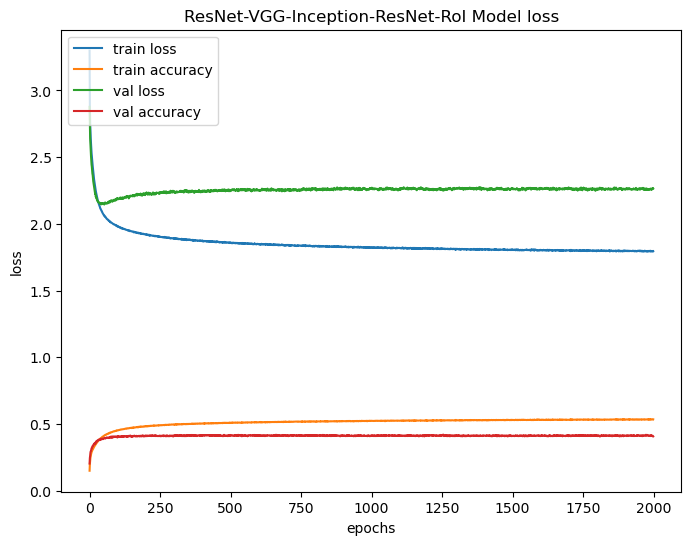

In [64]:
plot_train_loss(history, 'ResNet-VGG-Inception-ResNet-RoI Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [65]:
train_preds_no_pads = model1.predict(fine_tune_data_train_no_pads)

  33/7586 [..............................] - ETA: 24s 

2022-10-11 01:27:16.156232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7586/7586 [==============================] - 23s 3ms/step


In [83]:
train_pred_labels_no_pads = np.argmax(train_preds_no_pads, axis=-1)

In [84]:
train_pred_labels_no_pads

array([1, 1, 1, ..., 9, 9, 9])

In [106]:
train_pred_labels = list()
k = 0
for i in range(len(roi_count_train)):
    train_pred_labels.append(list(train_pred_labels_no_pads[k:(k+roi_count_train[i])]))
    k += roi_count_train[i]

In [107]:
train_pred_labels = np.array([pd.value_counts(ens_pred).index[0] if len(ens_pred) > 0 else -1 for ens_pred in train_pred_labels])

In [109]:
np.sum(train_pred_labels == train_labels['label'])

14356

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [110]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
11,11,./Data/train/train/11.tif,1
15,15,./Data/train/train/15.tif,8
16,16,./Data/train/train/16.tif,10
21,22,./Data/train/train/22.tif,8
28,30,./Data/train/train/30.tif,8
...,...,...,...
15151,15950,./Data/train/train/15950.tif,13
15159,15958,./Data/train/train/15958.tif,11
15166,15965,./Data/train/train/15965.tif,5
15177,15976,./Data/train/train/15976.tif,2


In [111]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

/Users/rishideychowdhury/Desktop/Document-Classification/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,fscore,support
0,0.000000,0.000000,0.000000,0
1,0.749214,0.974438,0.847111,978
2,0.967462,0.964324,0.965891,925
3,0.972281,0.985946,0.979066,925
4,0.906931,0.967265,0.936127,947
5,0.985539,0.952688,0.968835,930
6,0.973893,0.891892,0.931091,962
7,0.942693,0.988978,0.965281,998
8,0.984683,0.985761,0.985222,913
9,0.987179,0.766169,0.862745,1005


#### On Train-Test Data

In [112]:
test_preds = model1.predict(fine_tune_data_test_no_pads)

412/412 [==============================] - 1s 3ms/step


In [113]:
test_pred_labels_no_pads = np.argmax(test_preds, axis=-1)

In [114]:
test_pred_labels_no_pads

array([11,  3,  6, ...,  6,  6,  6])

In [115]:
test_pred_labels = list()
k = 0
for i in range(len(roi_count_test)):
    test_pred_labels.append(list(test_pred_labels_no_pads[k:(k+roi_count_test[i])]))
    k += roi_count_test[i]

In [117]:
test_pred_labels = np.array([pd.value_counts(ens_pred).index[0] if len(ens_pred) > 0 else -1 for ens_pred in test_pred_labels])

In [118]:
np.sum(test_pred_labels == test_labels['label'])

526

In [119]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
7,100,./Data/train/train/100.tif,10
...,...,...,...
785,15621,./Data/train/train/15621.tif,15
786,15660,./Data/train/train/15660.tif,4
787,15668,./Data/train/train/15668.tif,11
788,15687,./Data/train/train/15687.tif,12


In [120]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.383838,0.703704,0.496732,54
1,0.550000,0.750000,0.634615,44
2,0.948718,0.860465,0.902439,43
3,0.578125,0.804348,0.672727,46
4,0.766667,0.638889,0.696970,36
5,0.708333,0.340000,0.459459,50
6,0.627119,0.804348,0.704762,46
7,0.816327,0.769231,0.792079,52
8,0.846154,0.407407,0.550000,54
9,0.607843,0.659574,0.632653,47


In [121]:
np.mean(fscore)

0.6561534764075567

#### On Validation Data

Generating Predictions for the Validation Set

In [122]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [123]:
fine_tune_data_resnet_validation = np.load('./Data/ResNet-kP-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_resnet_validation.shape

(900, 100, 2048)

In [124]:
fine_tune_data_vgg_validation = np.load('./Data/VGG16-kP-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_vgg_validation.shape

(900, 100, 512)

In [125]:
fine_tune_data_inception_resnet_validation = np.load('./Data/Inception-ResNet-kP-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_inception_resnet_validation.shape

(900, 100, 1536)

In [270]:
fine_tune_data_validation_resnet = np.load('./Data/ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_resnet.shape

(900, 5, 2048)

In [126]:
fine_tune_data_validation = np.concatenate([fine_tune_data_resnet_validation, fine_tune_data_vgg_validation, fine_tune_data_inception_resnet_validation], axis=-1)
del fine_tune_data_resnet_validation
del fine_tune_data_vgg_validation
del fine_tune_data_inception_resnet_validation
fine_tune_data_validation.shape

(900, 100, 4096)

In [127]:
np.save('./Data/ResNet-VGG-Inception-kP-validation-precompute/whole_validation_data_precomp.npy', fine_tune_data_validation)

In [128]:
fine_tune_data_validation = np.load('./Data/ResNet-VGG-Inception-kP-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation.shape

(900, 100, 4096)

In [129]:
roi_info_validation = np.load('./Data/ROI-Extractions/validation/validation_roi_viz.npy')
roi_info_validation.shape

(900, 100, 6)

In [130]:
roi_count_validation = [np.sum([roi[-1]==1 for roi in doc]) for doc in roi_info_validation] # RoIs per document Image

In [131]:
fine_tune_data_validation_no_pads = np.concatenate([fine_tune_data_validation[i,:roi_count_validation[i],:] for i in range(fine_tune_data_validation.shape[0])])
fine_tune_data_validation_no_pads.shape

(14540, 4096)

In [132]:
np.save('./Data/ResNet-VGG-Inception-kP-validation-precompute/whole_validation_data_precomp_no_pads.npy', fine_tune_data_validation_no_pads)

In [133]:
fine_tune_data_validation_no_pads = np.load('./Data/ResNet-VGG-Inception-kP-validation-precompute/whole_validation_data_precomp_no_pads.npy')
fine_tune_data_validation_no_pads.shape

(14540, 4096)

In [271]:
# fine_tune_data_validation_vgg = np.load('./Data/VGG16-4P-validation-precompute/whole_validation_data_precomp.npy')
# fine_tune_data_validation_vgg.shape

(900, 5, 512)

In [272]:
# fine_tune_data_validation_inception_resnet = np.load('./Data/Inception-ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
# fine_tune_data_validation_inception_resnet.shape

(900, 5, 1536)

In [273]:
# fine_tune_data_validation_red_resnet = np.zeros((fine_tune_data_validation_resnet.shape[0], 5, N_COMPS_1))
# for i in range(5):
#     fine_tune_data_validation_red_resnet[:,i,:] = pcas_resnet[i].transform(fine_tune_data_validation_resnet[:,i,:])
# fine_tune_data_validation_resnet = fine_tune_data_validation_red_resnet
# del fine_tune_data_validation_red_resnet
# fine_tune_data_validation_resnet.shape

(900, 5, 1300)

In [274]:
# fine_tune_data_validation_red_vgg = np.zeros((fine_tune_data_validation_vgg.shape[0], 5, N_COMPS_2))
# for i in range(5):
#     fine_tune_data_validation_red_vgg[:,i,:] = pcas_vgg[i].transform(fine_tune_data_validation_vgg[:,i,:])
# fine_tune_data_validation_vgg = fine_tune_data_validation_red_vgg
# del fine_tune_data_validation_red_vgg
# fine_tune_data_validation_vgg.shape

(900, 5, 300)

In [275]:
# fine_tune_data_validation_red_inception_resnet = np.zeros((fine_tune_data_validation_inception_resnet.shape[0], 5, N_COMPS_3))
# for i in range(5):
#     fine_tune_data_validation_red_inception_resnet[:,i,:] = pcas_inception_resnet[i].transform(fine_tune_data_validation_inception_resnet[:,i,:])
# fine_tune_data_validation_inception_resnet = fine_tune_data_validation_red_inception_resnet
# del fine_tune_data_validation_red_inception_resnet
# fine_tune_data_validation_inception_resnet.shape

(900, 5, 900)

In [276]:
# fine_tune_data_validation = np.concatenate([fine_tune_data_validation_resnet, fine_tune_data_validation_vgg, fine_tune_data_validation_inception_resnet], axis=-1)
# fine_tune_data_validation.shape

(900, 5, 2500)

In [277]:
# valid_preds = model1.predict(fine_tune_data_validation)

29/29 [==============================] - 0s 3ms/step


2022-10-09 15:57:30.272902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [278]:
# valid_pred_labels = np.argmax(valid_preds, axis=-1)

## Extract the Feature Vectors for the ROIs

In [136]:
model2 = tf.keras.Model(model1.input, model1.get_layer(index=len(model1.layers)-4).output)

In [137]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4096)]            0         
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 2048)              8390656   
                                                                 
 batch_normalization_5 (Batc  (None, 2048)             8192      
 hNormalization)                                             

In [138]:
train_embed = model2.predict(fine_tune_data_train_no_pads)

  69/7586 [..............................] - ETA: 17s

2022-10-11 02:29:21.061007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7586/7586 [==============================] - 14s 2ms/step


In [141]:
train_embed.shape

(242726, 512)

In [154]:
fine_tune_train_embed = list()
k = 0
for i in range(len(roi_count_train)):
    fine_tune_train_embed.append(np.concatenate([train_embed[k:k+roi_count_train[i]], np.zeros((100-roi_count_train[i], 512))])[np.newaxis,:])
    k += roi_count_train[i]
fine_tune_train_embed = np.concatenate(fine_tune_train_embed)

In [155]:
fine_tune_train_embed.shape

(15200, 100, 512)

In [156]:
np.save('./Data/ResNet-VGG-Inception-kP-train-precompute/whole_train_train_embed_precomp.npy', fine_tune_train_embed)

In [142]:
test_embed = model2.predict(fine_tune_data_test_no_pads)

412/412 [==============================] - 1s 2ms/step


In [143]:
test_embed.shape

(13154, 512)

In [160]:
fine_tune_test_embed = list()
k = 0
for i in range(len(roi_count_test)):
    fine_tune_test_embed.append(np.concatenate([test_embed[k:k+roi_count_test[i]], np.zeros((100-roi_count_test[i], 512))])[np.newaxis,:])
    k += roi_count_test[i]
fine_tune_test_embed = np.concatenate(fine_tune_test_embed)

In [161]:
fine_tune_test_embed.shape

(800, 100, 512)

In [162]:
np.save('./Data/ResNet-VGG-Inception-kP-train-precompute/whole_train_test_embed_precomp.npy', fine_tune_test_embed)

In [148]:
validation_embed = model2.predict(fine_tune_data_validation_no_pads)

455/455 [==============================] - 1s 2ms/step


In [166]:
validation_embed.shape

(14540, 512)

In [168]:
len(roi_count_validation)

900

In [169]:
fine_tune_validation_embed = list()
k = 0
for i in range(len(roi_count_validation)):
    fine_tune_validation_embed.append(np.concatenate([validation_embed[k:k+roi_count_validation[i]], np.zeros((100-roi_count_validation[i], 512))])[np.newaxis,:])
    k += roi_count_validation[i]
fine_tune_validation_embed = np.concatenate(fine_tune_validation_embed)

In [170]:
fine_tune_validation_embed.shape

(900, 100, 512)

In [171]:
np.save('./Data/ResNet-VGG-Inception-kP-validation-precompute/whole_validation_embed_precomp.npy', fine_tune_validation_embed)